# TM-G testing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('Data/hourly_data_ff.csv')
time = df['timestamp']
df.drop(columns=['timestamp'], inplace=True)

In [3]:
dfs = np.array_split(df,10)
times = np.array_split(time,10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


The Granger causality test indicates that the only orderbook features that cause the volatility are ask_depth, bid_depth, bid_volume, spread and volume_difference. We thus train the model using only these features.


In [ ]:
from Models.TM_G import TM_G
from Model_eval.TM_eval import evaluate_TM
from sklearn.preprocessing import StandardScaler
from Models.CVal import cross_validation
import copy

useful_features = ['ask_depth', 'bid_depth', 'bid_volume', 'spread', 'volume_difference']
useful_cols = useful_features + ['vol']
predictions = []
for i in range(3, 9):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)[useful_cols]
  df_validate = copy.deepcopy(dfs[i])[useful_cols].iloc[5:]
  df_test =copy.deepcopy(dfs[i+1])[useful_cols].iloc[5:]

  best_params = cross_validation(copy.deepcopy(df_train), copy.deepcopy(df_validate), useful_features)
  print(f'Cross validated interval {i}')

  model = TM_G(n_features = len(useful_features), lb = best_params['lb'], lambda_reg = best_params['lambda_reg'])
  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()
  new_df_train[useful_features] = scaler.fit_transform(new_df_train[useful_features])
  model.train_model(df_train, epochs = 2000)
  df_test[useful_features] = scaler.transform(df_test[useful_features])
  print(f'Predicted interval {i+1}')

  _, _, y_pred, _ = evaluate_TM(model, df_test, plot = False)
  predictions.append(y_pred)

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/augustedarracqparies/Documents/Master/Paper ML/Git Code/TMM-for-BTC-volatility-prediction/Models/TM_G.py:76: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  g_order = F.softplus(self.A.T @ order_book_feats @ self.B, beta = 1)
100%|██████████| 2000/2000 [00:03<00:00, 602.45it/s]


Cross validated interval 3


100%|██████████| 2000/2000 [00:03<00:00, 625.36it/s]


Predicted interval 4


100%|██████████| 2000/2000 [00:03<00:00, 586.73it/s]


Cross validated interval 4


100%|██████████| 2000/2000 [00:02<00:00, 756.93it/s]


Predicted interval 5


100%|██████████| 2000/2000 [00:03<00:00, 512.23it/s]


Cross validated interval 5


100%|██████████| 2000/2000 [00:02<00:00, 803.00it/s] 


Predicted interval 6


100%|██████████| 2000/2000 [00:02<00:00, 697.29it/s]


Cross validated interval 6


100%|██████████| 2000/2000 [00:03<00:00, 631.95it/s]


Predicted interval 7


100%|██████████| 2000/2000 [00:04<00:00, 444.65it/s]


Cross validated interval 7


100%|██████████| 2000/2000 [00:02<00:00, 953.96it/s] 


Predicted interval 8


100%|██████████| 2000/2000 [00:02<00:00, 773.13it/s]


Cross validated interval 8


100%|██████████| 2000/2000 [00:03<00:00, 550.07it/s]


Predicted interval 9


In [ ]:
final_pred = [predictions[j][i] for j in range(1,len(predictions)) for i in range(len(predictions[j])) ]
print(len(final_pred))
dfs = [dfs[i][31:] for i in range(10)]
merged = pd.concat(dfs[4:], ignore_index=True).reset_index(drop = True)
print(merged.shape)

1375
(1375, 11)


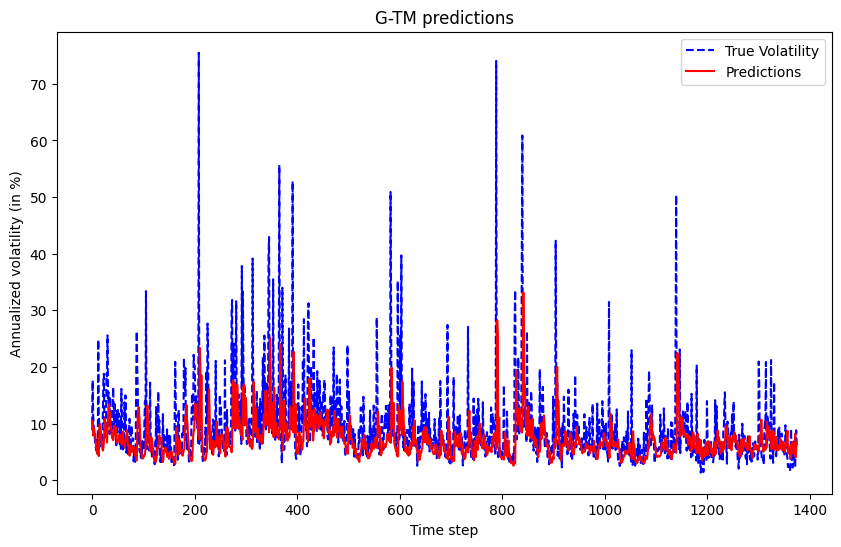

In [7]:
plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red')
plt.title('G-TM predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for i in range(4,10):
  start = int(np.sum([len(dfs[j]) for j in range(4, i)]))
  rmse = np.sqrt(mean_squared_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])])) / 100 # Undo percentage scaling
  mae = mean_absolute_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])]) / 100 
  print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Test RMSE: 0.0739, MAE: 0.0423
Test RMSE: 0.0907, MAE: 0.0541
Test RMSE: 0.0637, MAE: 0.0374
Test RMSE: 0.0873, MAE: 0.0428
Test RMSE: 0.0531, MAE: 0.0281
Test RMSE: 0.0363, MAE: 0.0243


In [12]:
dfs = np.array_split(df,10)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


We now check if adding our remaining features lead to improved performance.

In [ ]:
feature_cols = df.columns.difference(['vol'])
predictions = []
for i in range(3, 9):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)
  df_validate = copy.deepcopy(dfs[i])
  df_test =copy.deepcopy(dfs[i+1])

  best_params = cross_validation(copy.deepcopy(df_train), copy.deepcopy(df_validate))
  print(f'Cross validated interval {i}')

  model = TM_G(n_features = df_train.shape[1]-1, lb = best_params['lb'], lambda_reg = best_params['lambda_reg'])
  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()
  new_df_train[feature_cols] = scaler.fit_transform(new_df_train[feature_cols])
  model.train_model(df_train, epochs = 2000)
  df_test[feature_cols] = scaler.transform(df_test[feature_cols])
  print(f'Predicted interval {i+1}')

  _, _, y_pred, _ = evaluate_TM(model, df_test, plot = False)
  predictions.append(y_pred)

100%|██████████| 2000/2000 [00:03<00:00, 643.87it/s]


Cross validated interval 4


100%|██████████| 2000/2000 [00:03<00:00, 626.00it/s]


Predicted interval 5


100%|██████████| 2000/2000 [00:03<00:00, 658.67it/s]


Cross validated interval 5


100%|██████████| 2000/2000 [00:02<00:00, 981.36it/s] 


Predicted interval 6


100%|██████████| 2000/2000 [00:04<00:00, 499.47it/s]


Cross validated interval 6


100%|██████████| 2000/2000 [00:02<00:00, 920.42it/s] 


Predicted interval 7


100%|██████████| 2000/2000 [00:03<00:00, 511.02it/s]


Cross validated interval 7


100%|██████████| 2000/2000 [00:02<00:00, 748.46it/s]


Predicted interval 8


100%|██████████| 2000/2000 [00:03<00:00, 545.31it/s]


Cross validated interval 8


100%|██████████| 2000/2000 [00:01<00:00, 1021.96it/s]

Predicted interval 9


In [ ]:
final_pred = [predictions[j][i] for j in range(1,len(predictions)) for i in range(len(predictions[j])) ]
print(len(final_pred))
dfs = [dfs[i][31:] for i in range(10)]
merged = pd.concat(dfs[4:], ignore_index=True).reset_index(drop = True)
print(merged.shape)

1375
(1375, 11)


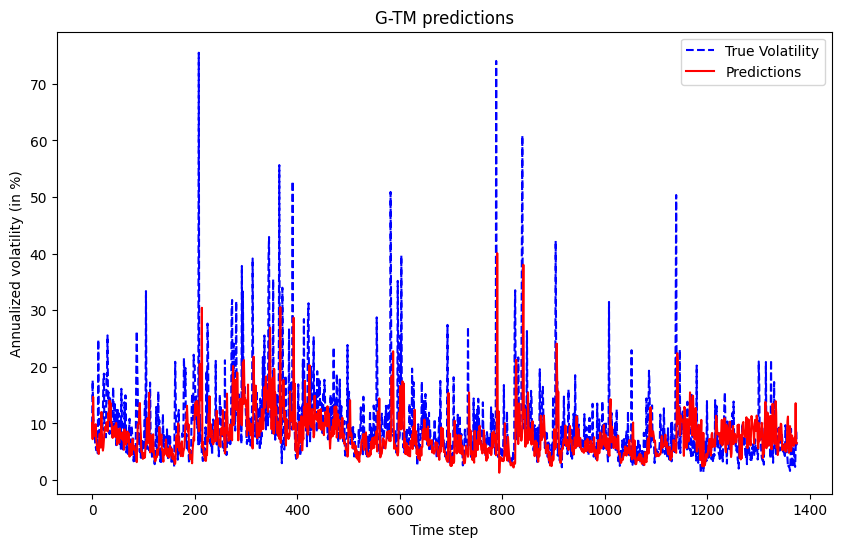

In [15]:
plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red')
plt.title('G-TM predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for i in range(4,10):
  start = int(np.sum([len(dfs[j]) for j in range(4, i)]))
  rmse = np.sqrt(mean_squared_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])])) / 100 # Undo percentage scaling
  mae = mean_absolute_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])]) / 100 
  print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Test RMSE: 0.0762, MAE: 0.0440
Test RMSE: 0.0873, MAE: 0.0541
Test RMSE: 0.0641, MAE: 0.0383
Test RMSE: 0.0904, MAE: 0.0451
Test RMSE: 0.0532, MAE: 0.0293
Test RMSE: 0.0436, MAE: 0.0330


# Sentiment TM-G testing

The granger causality test indicates that our sentiment time series Granger-causes the volatility up to two lags, so we choose the look back window for the sentiment component to be 2.

In [7]:
sent = pd.read_csv('Data/sentiment.csv')

In [8]:
dfs = np.array_split(df,10)
sents = np.array_split(sent,10)

for i in range(10):
    dfs[i]['sentiment'] = sents[i]['Aggregate sentiment'].values


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [10]:
import matplotlib.pyplot as plt
from Models.TM_SG import TM_SG
from Model_eval.TM_eval import evaluate_STM
from sklearn.preprocessing import StandardScaler
from Models.CVal import cross_validation_S
import copy
useful_features = ['ask_depth', 'bid_depth', 'bid_volume', 'spread', 'volume_difference']
useful_cols = useful_features + ['vol', 'sentiment']
predictions = []
for i in range(3, 9):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)[useful_cols]
  df_validate = copy.deepcopy(dfs[i])[useful_cols]
  df_test =copy.deepcopy(dfs[i+1])[useful_cols]

  best_params = cross_validation_S(copy.deepcopy(df_train), copy.deepcopy(df_validate), useful_features)
  print(f'Cross validated interval {i}')

  model = TM_SG(n_features = len(useful_features), lb = best_params['lb'], lambda_reg = best_params['lambda_reg'])
  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()
  new_df_train[useful_features] = scaler.fit_transform(new_df_train[useful_features])
  model.train_model(df_train, epochs = 2000)
  df_test[useful_features] = scaler.transform(df_test[useful_features])
  print(f'Predicted interval {i+1}')

  _, _, y_pred = evaluate_STM(model, df_test, plot = False)
  predictions.append(y_pred)

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/augustedarracqparies/Documents/Master/Paper ML/Git Code/TMM-for-BTC-volatility-prediction/Models/TM_SG.py:76: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  g_order = F.softplus(self.A.T @ order_book_feats @ self.B)
100%|██████████| 2000/2000 [00:03<00:00, 631.67it/s]


Cross validated interval 3


100%|██████████| 2000/2000 [00:02<00:00, 856.33it/s]


Predicted interval 4


100%|██████████| 2000/2000 [00:02<00:00, 707.15it/s]


Cross validated interval 4


100%|██████████| 2000/2000 [00:02<00:00, 869.78it/s]


Predicted interval 5


100%|██████████| 2000/2000 [00:02<00:00, 711.01it/s]


Cross validated interval 5


100%|██████████| 2000/2000 [00:02<00:00, 894.09it/s]


Predicted interval 6


100%|██████████| 2000/2000 [00:03<00:00, 653.34it/s]


Cross validated interval 6


100%|██████████| 2000/2000 [00:02<00:00, 896.31it/s]


Predicted interval 7


100%|██████████| 2000/2000 [00:02<00:00, 714.44it/s]


Cross validated interval 7


100%|██████████| 2000/2000 [00:02<00:00, 922.14it/s]


Predicted interval 8


100%|██████████| 2000/2000 [00:03<00:00, 654.72it/s]


Cross validated interval 8


100%|██████████| 2000/2000 [00:02<00:00, 676.03it/s]

Predicted interval 9


In [ ]:
final_pred = [predictions[j][i] for j in range(len(predictions)) for i in range(len(predictions[j])) ]
print(len(final_pred))
dfs = [dfs[i][31:] for i in range(10)]
merged = pd.concat(dfs[4:], ignore_index=True).reset_index(drop = True)
print(merged.shape)

1375
(1375, 11)


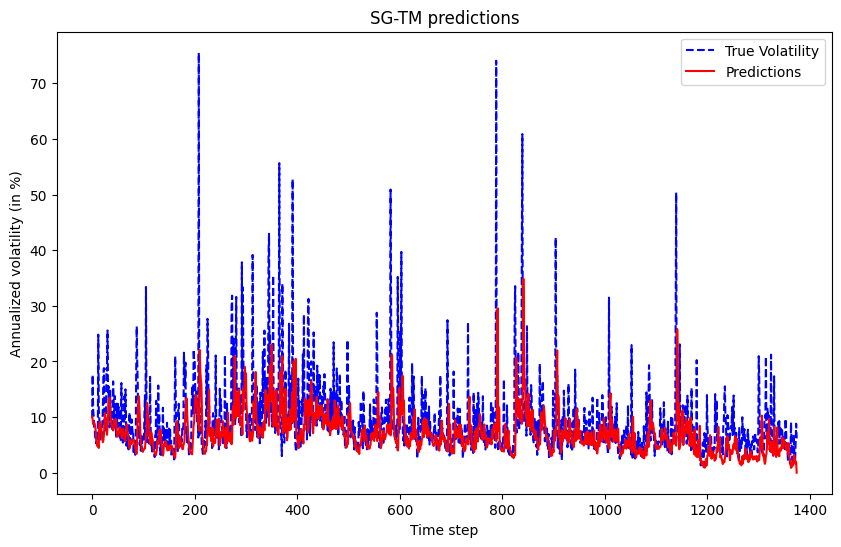

In [87]:
plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red')
plt.title('SG-TM predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()

In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for i in range(4,10):
  start = int(np.sum([len(dfs[j]) for j in range(4, i)]))
  rmse = np.sqrt(mean_squared_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])])) / 100 # Undo percentage scaling
  mae = mean_absolute_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])]) / 100 
  print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Test RMSE: 0.0742, MAE: 0.0427
Test RMSE: 0.0908, MAE: 0.0554
Test RMSE: 0.0633, MAE: 0.0371
Test RMSE: 0.0881, MAE: 0.0437
Test RMSE: 0.0534, MAE: 0.0294
Test RMSE: 0.0464, MAE: 0.0327


# LSTMX

(522, 6)
(261, 6)
(261, 6)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cross validated interval 3
(783, 6)
Predicted interval 4
(522, 6)
(261, 6)
(260, 6)
Cross validated interval 4
(783, 6)
Predicted interval 5
(522, 6)
(260, 6)
(260, 6)
Cross validated interval 5
(782, 6)
Predicted interval 6
(522, 6)
(260, 6)
(260, 6)
Cross validated interval 6
(782, 6)
Predicted interval 7
(521, 6)
(260, 6)
(260, 6)
Cross validated interval 7
(781, 6)
Predicted interval 8
(520, 6)
(260, 6)
(260, 6)
Cross validated interval 8
(780, 6)
Predicted interval 9
RMSE on each interval:  [6.7816014, 8.284238, 5.551058, 7.208822, 5.38882, 5.2413087]
MAE on each interval: [3.5175238, 6.725178, 3.5572486, 3.6278117, 4.2395844, 4.733641]
Size of the merged dataset: (1471, 11)


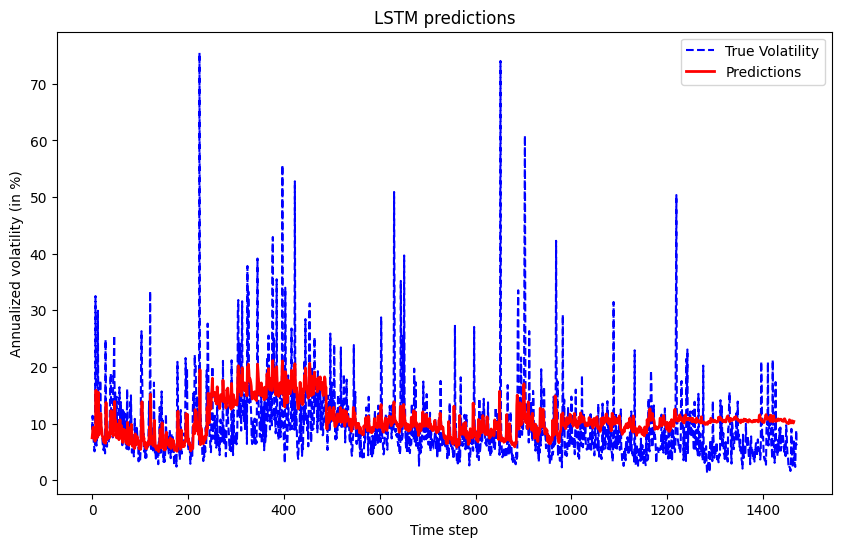

In [ ]:
from Models.LSTM import *
from Model_eval.LSTM_eval import *
from Models.CVal_LSTM import *
import copy
predictions = []
rmse_list = []
mae_list = []
useful_features =  ['ask_depth', 'bid_depth', 'bid_volume', 'spread', 'volume_difference']
feature_cols = useful_features
useful_cols = feature_cols + ['vol']
for i in range(3, 9):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)[useful_cols]
  df_validate = copy.deepcopy(dfs[i])[useful_cols]
  df_test =copy.deepcopy(dfs[i+1])[useful_cols]


  X_train_vol, X_train_orderbook, y_train = prepare_data_from_metrics(
    df_train,
    orderbook_timesteps=15,
    future_horizon=1
)
  X_val_vol, X_val_orderbook, y_val = prepare_data_from_metrics(
    df_validate,
    orderbook_timesteps=15,
    future_horizon=1
)


  X_test_vol, X_test_orderbook, y_test = prepare_data_from_metrics(
    df_test,
    orderbook_timesteps=15,
    future_horizon=1
)

  model, best_params, best_rmse = grid_search_LSTM(
    param_grid,
    X_train_vol, X_train_orderbook, y_train,
    X_val_vol, X_val_orderbook, y_val,
    epochs=5,
)



  print(f'Cross validated interval {i}')


  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()

  new_df_train[feature_cols] = scaler.fit_transform(new_df_train[feature_cols])

  X_volatility, X_orderbook, y = prepare_data_from_metrics(
    new_df_train,
    orderbook_timesteps=15,
    future_horizon=1
)


  model.train_model(X_volatility, X_orderbook,y)

  df_test[feature_cols] = scaler.transform(df_test[feature_cols])
  print(f'Predicted interval {i+1}')

  rmse, mae, _, y_pred = evaluate_model_mse(model, X_test_vol, X_test_orderbook, y_test)
  predictions.append(y_pred)
  rmse_list.append(rmse)
  mae_list.append(mae)



final_pred = [pred for interval in predictions for pred in interval]


print('RMSE on each interval: ',rmse_list)
print('MAE on each interval:', mae_list)
timesteps_lost = 15
dfs_trimmed = [dfs[i][timesteps_lost:].reset_index(drop=True) for i in range(10)]
merged = pd.concat(dfs_trimmed[4:10], ignore_index=True)
print(f"Size of the merged dataset: {merged.shape}")




plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red', linewidth = 2)
plt.title('LSTM predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()



# HAR models

[Window 1] Selected windows: [1, 2, 3, 25]
[Window 2] Selected windows: [1, 2, 28]
[Window 3] Selected windows: [1, 2, 7, 15, 17, 27, 29]
[Window 4] Selected windows: [1, 2, 4, 5, 9, 16, 17, 21, 27]
[Window 5] Selected windows: [1, 2, 8, 16, 17, 21, 27]
[Window 6] Selected windows: [1, 21, 27]
Window 1: MAE = 0.0368, RMSE = 0.0657
Window 2: MAE = 0.0457, RMSE = 0.0753
Window 3: MAE = 0.0347, RMSE = 0.0547
Window 4: MAE = 0.0371, RMSE = 0.0719
Window 5: MAE = 0.0326, RMSE = 0.0515
Window 6: MAE = 0.0270, RMSE = 0.0363


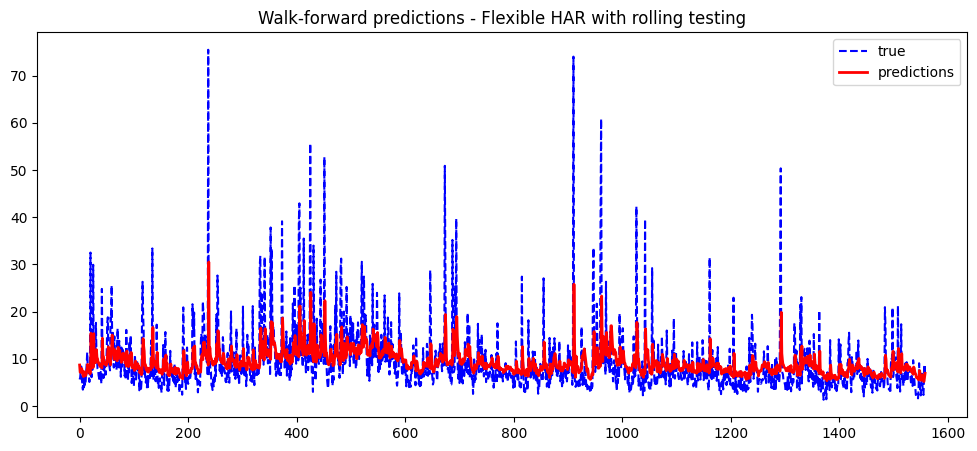

[Window 1] Selected windows: [1, 6, 24]
[Window 2] Selected windows: [1, 6, 24]
[Window 3] Selected windows: [1, 6, 24]
[Window 4] Selected windows: [1, 6, 24]
[Window 5] Selected windows: [1, 6, 24]
[Window 6] Selected windows: [1, 6, 24]
Window 1: MAE = 0.0371, RMSE = 0.0658
Window 2: MAE = 0.0457, RMSE = 0.0756
Window 3: MAE = 0.0348, RMSE = 0.0552
Window 4: MAE = 0.0371, RMSE = 0.0708
Window 5: MAE = 0.0326, RMSE = 0.0509
Window 6: MAE = 0.0272, RMSE = 0.0365


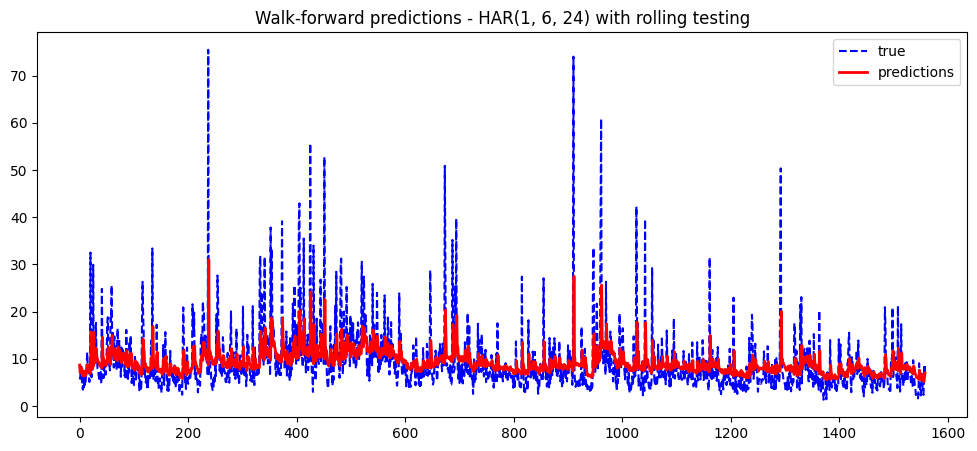

[Window 1] Selected features: ['roll_1', 'roll_2', 'roll_3', 'roll_25', 'ask_depth_lag0', 'ask_volume_lag3']
[Window 2] Selected features: ['roll_1', 'roll_2', 'roll_28']
[Window 3] Selected features: ['roll_1', 'roll_2', 'roll_27', 'roll_29', 'spread_lag1']
[Window 4] Selected features: ['roll_1', 'roll_2', 'roll_27', 'spread_lag0', 'spread_lag1', 'spread_lag3', 'spread_lag4', 'weighted_spread_lag4', 'spread_lag6', 'bid_slope_lag6', 'spread_lag9']
[Window 5] Selected features: ['roll_1', 'roll_2', 'roll_27', 'spread_lag0', 'spread_lag1', 'spread_lag2', 'bid_volume_lag2', 'spread_lag4', 'bid_depth_lag8']
[Window 6] Selected features: ['roll_1', 'roll_8', 'roll_21', 'roll_27', 'spread_lag2', 'ask_slope_lag2', 'bid_depth_lag9']


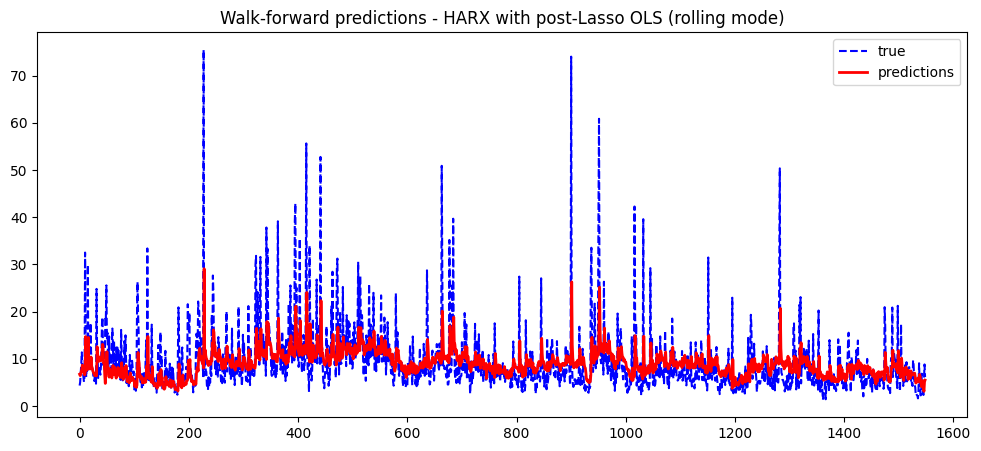

   window       MAE      RMSE  \
0       1  0.038137  0.070204   
1       2  0.047076  0.077007   
2       3  0.033022  0.052894   
3       4  0.039829  0.074572   
4       5  0.033795  0.048452   
5       6  0.025835  0.035913   

                                   Selected Features  
0  [roll_1, roll_2, roll_3, roll_25, ask_depth_la...  
1                          [roll_1, roll_2, roll_28]  
2    [roll_1, roll_2, roll_27, roll_29, spread_lag1]  
3  [roll_1, roll_2, roll_27, spread_lag0, spread_...  
4  [roll_1, roll_2, roll_27, spread_lag0, spread_...  
5  [roll_1, roll_8, roll_21, roll_27, spread_lag2...  
[Window 1] Selected features: ['roll_1', 'roll_6', 'roll_24', 'ask_depth_lag0', 'ask_volume_lag3']
[Window 2] Selected features: ['roll_1', 'roll_6', 'roll_24']
[Window 3] Selected features: ['roll_1', 'roll_6', 'roll_24', 'spread_lag1']
[Window 4] Selected features: ['roll_1', 'roll_6', 'roll_24', 'spread_lag0', 'spread_lag1', 'spread_lag3', 'spread_lag4', 'weighted_spread_lag4',

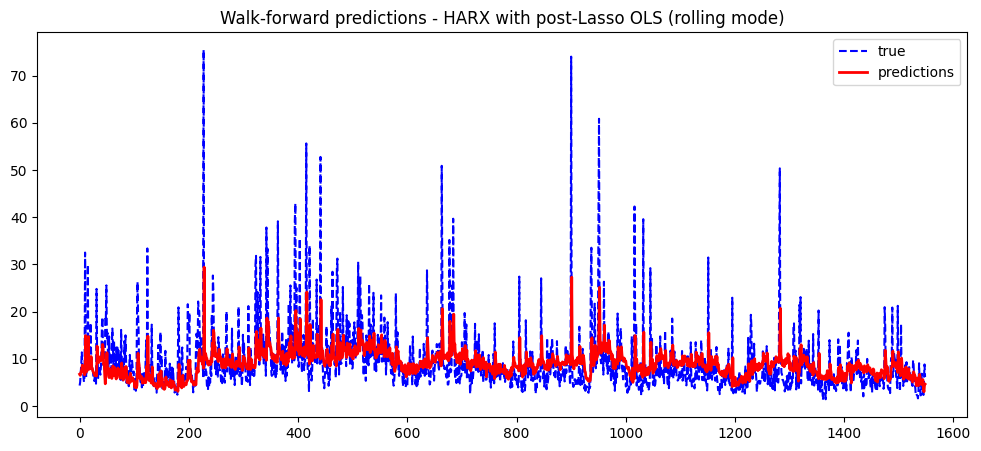

   window       MAE      RMSE  \
0       1  0.038646  0.070617   
1       2  0.047122  0.077297   
2       3  0.033128  0.053036   
3       4  0.040293  0.074511   
4       5  0.034387  0.048611   
5       6  0.025771  0.035814   

                                   Selected Features  
0  [roll_1, roll_6, roll_24, ask_depth_lag0, ask_...  
1                          [roll_1, roll_6, roll_24]  
2             [roll_1, roll_6, roll_24, spread_lag1]  
3  [roll_1, roll_6, roll_24, spread_lag0, spread_...  
4  [roll_1, roll_6, roll_24, spread_lag0, spread_...  
5  [roll_1, roll_6, roll_24, spread_lag2, ask_slo...  


In [1]:
from Models.HAR import *
from Models.HARX import *
df = pd.read_csv('Data/hourly_data_ff.csv')
Y = df['vol'].values

#Flexible HAR
sim1 = HARSimulator(df=df, Y=Y, shift=1, mode='rolling', use_lasso=True)
sim1.add_rolling_features()
sim1.run_simulation()
sim1.plot_predictions()
sim1.summary()

#HAR
sim2 = HARSimulator(df=df, Y=Y, shift=1, mode='rolling', use_lasso=False, fixed_windows=[1, 6, 24])
sim2.add_rolling_features()
sim2.run_simulation()
sim2.plot_predictions()
sim2.summary()

#Flexible HARX
sim = HARXSimulator(df=df, Y=Y, shift=1, har_windows=False, mode='rolling',lag=10)
sim.add_rolling_features()
sim.run_simulation()
sim.plot_predictions()
sim.summary()


#HARX
sim = HARXSimulator(df=df, Y=Y, shift=1, har_windows=True, mode='rolling',lag=10)
sim.add_rolling_features()
sim.run_simulation()
sim.plot_predictions()
sim.summary()

# GARCH

In [4]:
import pandas as pd
df_returns = pd.read_csv(
    'Data/hourly_data_ff_with_returns.csv',
    parse_dates=['timestamp']
)
df_vol = pd.read_csv(
    'Data/hourly_data_ff.csv',
    parse_dates=['timestamp']
)

Starting lookback window optimization...
Starting volatility prediction...

Plotting GARCH predictions...


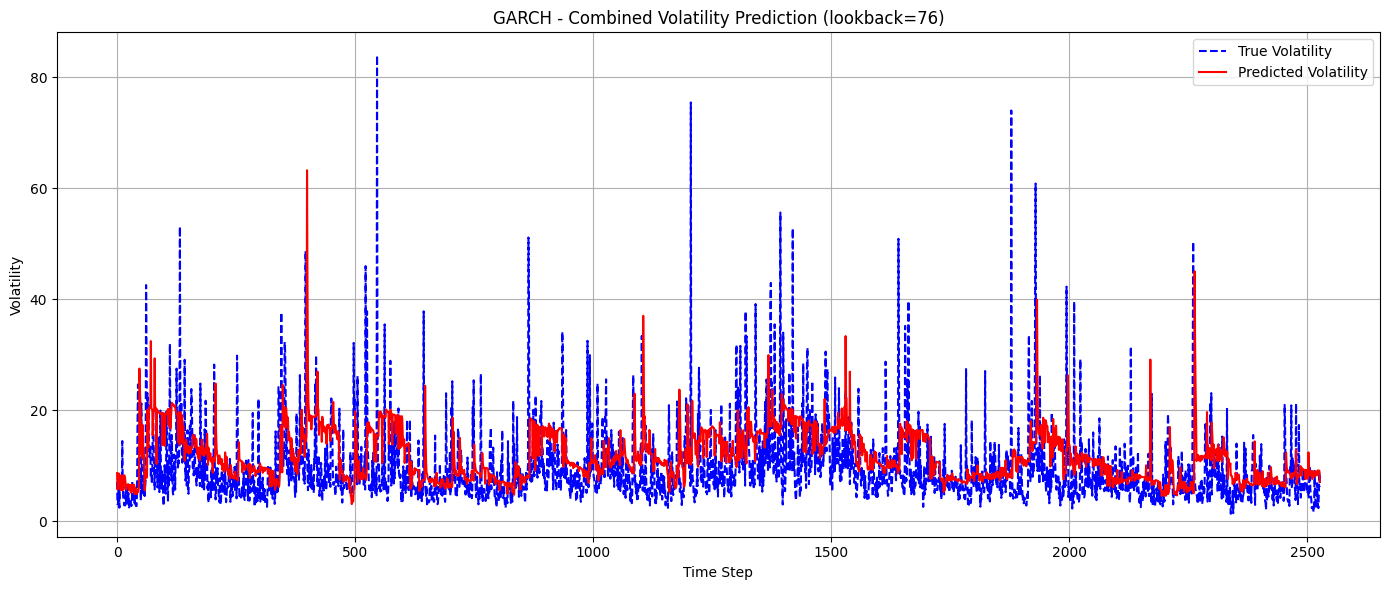

Interval 5: Mean RMSE = 0.0818, mean MAE = 0.0607
Interval 6: Mean RMSE = 0.0881, mean MAE = 0.0690
Interval 7: Mean RMSE = 0.0683, mean MAE = 0.0505
Interval 8: Mean RMSE = 0.0868, mean MAE = 0.0565
Interval 9: Mean RMSE = 0.0635, mean MAE = 0.0386
Interval 10: Mean RMSE = 0.0464, mean MAE = 0.0373


In [5]:
from Models.GARCH import test_garch
df_garch, _ = test_garch(df_returns, df_vol)

# XGBoost exclusively on historical volatility


[Window 1] Training on intervals 0-2, validating on 3, testing on 4


/Users/augustedarracqparies/Documents/Master/Paper ML/Git Code/TMM-for-BTC-volatility-prediction/Models/XGBoost.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_preds = pd.concat([all_preds, preds_df], ignore_index=True)



[Window 2] Training on intervals 1-3, validating on 4, testing on 5

[Window 3] Training on intervals 2-4, validating on 5, testing on 6

[Window 4] Training on intervals 3-5, validating on 6, testing on 7

[Window 5] Training on intervals 4-6, validating on 7, testing on 8

[Window 6] Training on intervals 5-7, validating on 8, testing on 9

[Summary]
   Window      RMSE       MAE
0       1  0.068413  0.039422
1       2  0.077689  0.049335
2       3  0.065345  0.042012
3       4  0.070766  0.037915
4       5  0.052391  0.034145
5       6  0.045888  0.034474


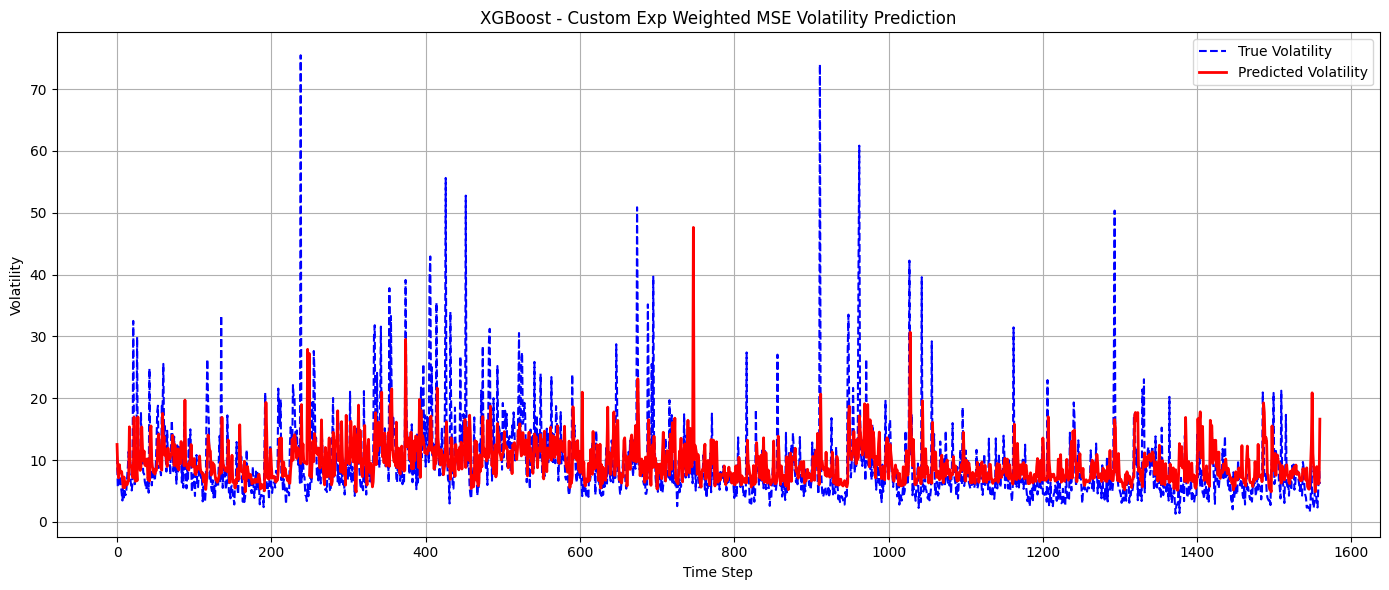

In [1]:
from Models.XGBoost import *
import numpy as np
import pandas as pd

df = pd.read_csv('DATA/hourly_data_ff.csv')

feat_lags = {}


results_df, all_preds, all_trues = test_xgboost(df, feat_lags = feat_lags)

# XGBoost with GCT features



[Window 1] Training on intervals 0-2, validating on 3, testing on 4


/Users/augustedarracqparies/Documents/Master/Paper ML/Git Code/TMM-for-BTC-volatility-prediction/Models/XGBoost.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_preds = pd.concat([all_preds, preds_df], ignore_index=True)



[Window 2] Training on intervals 1-3, validating on 4, testing on 5

[Window 3] Training on intervals 2-4, validating on 5, testing on 6

[Window 4] Training on intervals 3-5, validating on 6, testing on 7

[Window 5] Training on intervals 4-6, validating on 7, testing on 8

[Window 6] Training on intervals 5-7, validating on 8, testing on 9

[Summary]
   Window      RMSE       MAE
0       1  0.083179  0.063676
1       2  0.093947  0.067855
2       3  0.055923  0.034951
3       4  0.071971  0.040056
4       5  0.052828  0.035702
5       6  0.091175  0.083221


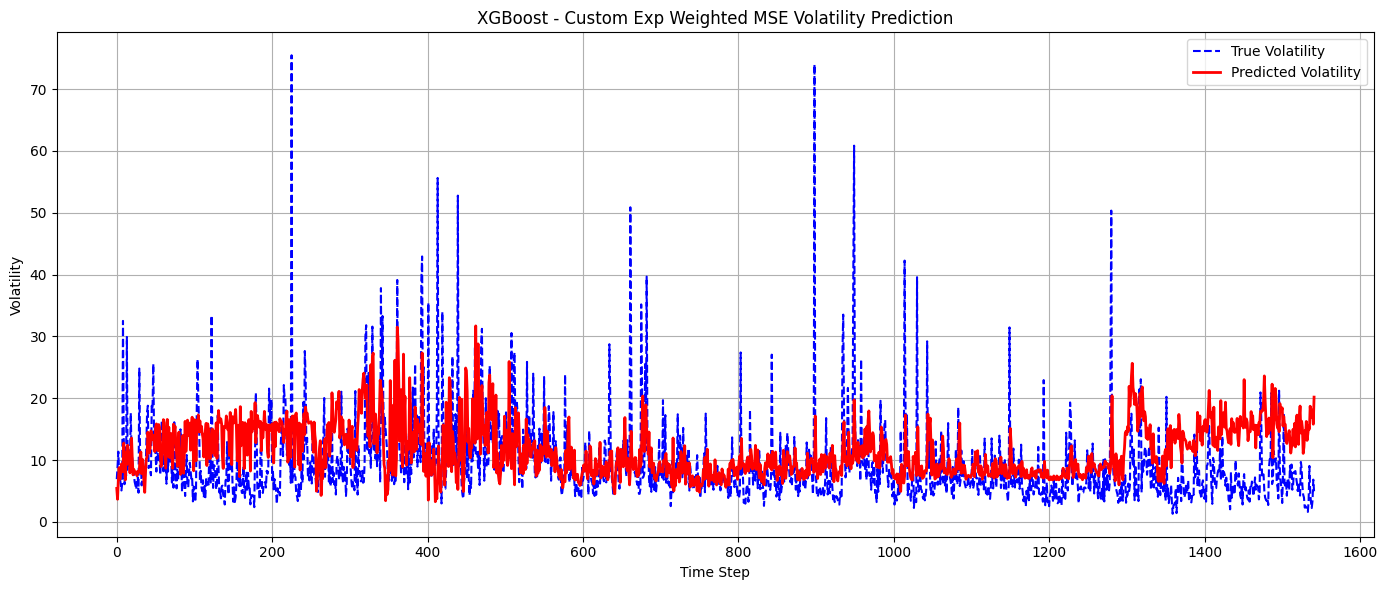

In [2]:
from Models.XGBoost import *
import numpy as np

df = pd.read_csv('DATA/hourly_data_ff.csv')
df_returns = pd.read_csv(
    'Data/hourly_data_ff_with_returns.csv',
    parse_dates=['timestamp']
)

feat_lags = {
    'aggregate_sentiment': 2,
    'fng_feature': 19,
    'ask_depth': 30,
    'bid_depth': 9,
    'bid_volume': 30,
    'spread':8,
    'volume_difference': 30,
    'returns': 1,
}
granger_features = ['ask_depth', 'bid_depth', 'bid_volume', 'spread', 'volume_difference']
df = pd.concat([df[granger_features + ['vol', 'timestamp']],np.abs( df_returns['returns'])], axis=1)


results_df, all_preds, all_trues = test_xgboost(df, feat_lags = feat_lags)

# XGBoost exclusively with sentiment


[Window 1] Training on intervals 0-2, validating on 3, testing on 4


/Users/augustedarracqparies/Documents/Master/Paper ML/Git Code/TMM-for-BTC-volatility-prediction/Models/XGBoost.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_preds = pd.concat([all_preds, preds_df], ignore_index=True)



[Window 2] Training on intervals 1-3, validating on 4, testing on 5

[Window 3] Training on intervals 2-4, validating on 5, testing on 6

[Window 4] Training on intervals 3-5, validating on 6, testing on 7

[Window 5] Training on intervals 4-6, validating on 7, testing on 8

[Window 6] Training on intervals 5-7, validating on 8, testing on 9

[Summary]
   Window      RMSE       MAE
0       1  0.070240  0.040817
1       2  0.079153  0.048217
2       3  0.071350  0.045016
3       4  0.070394  0.039659
4       5  0.053194  0.034665
5       6  0.049367  0.038170


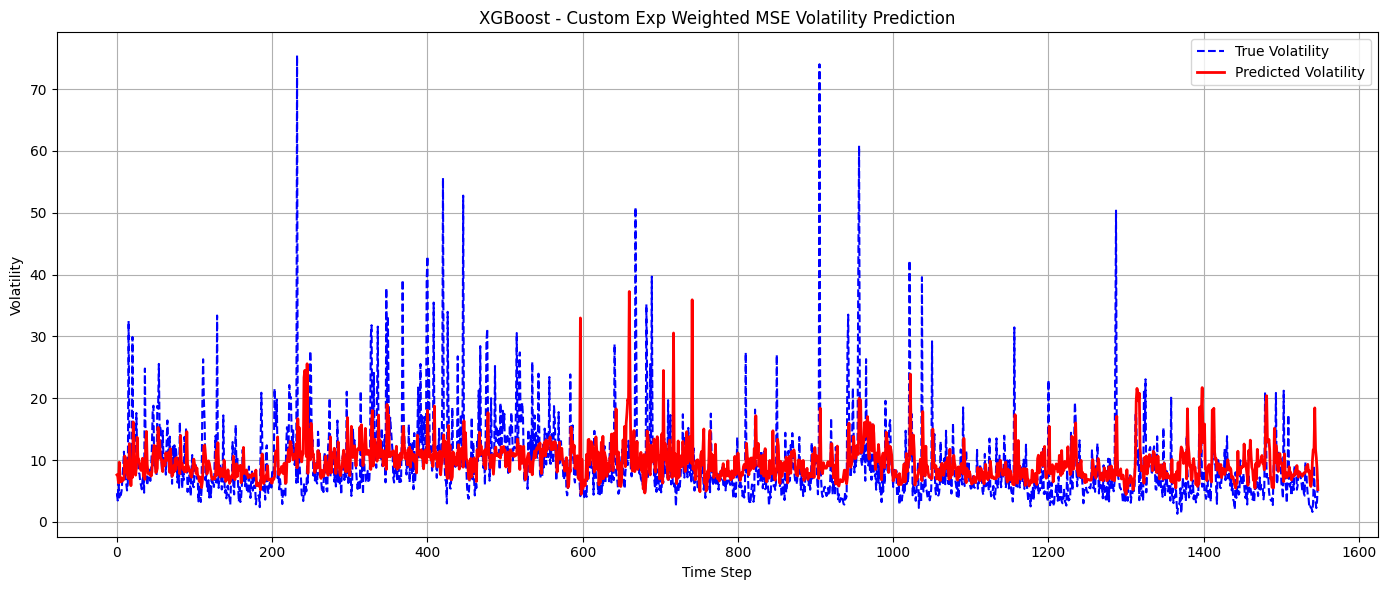

In [3]:
from Models.XGBoost import *

df = pd.read_csv('DATA/hourly_data_ff.csv')
sent = pd.read_csv('DATA/sentiment.csv')
df_returns = pd.read_csv(
    'Data/hourly_data_ff_with_returns.csv',
    parse_dates=['timestamp']
)

empty_features = []
df = df[empty_features + ['vol', 'timestamp']]
feat_lags = {
    'aggregate_sentiment': 2,
    'fng_feature': 19,
}

df = pd.concat([df, sent[['Aggregate sentiment', 'fng_feature']],np.abs( df_returns['returns'])], axis=1)

results_xgb, df_xgb, all_trues = test_xgboost(df, feat_lags=feat_lags)

# XGBoost x GARCH

(1548, 3)
Interval 1 - Test RMSE: 0.0704, MAE: 0.0462
Interval 2 - Test RMSE: 0.0781, MAE: 0.0546
Interval 3 - Test RMSE: 0.0646, MAE: 0.0461
Interval 4 - Test RMSE: 0.0740, MAE: 0.0439
Interval 5 - Test RMSE: 0.0546, MAE: 0.0352
Interval 6 - Test RMSE: 0.0454, MAE: 0.0371


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


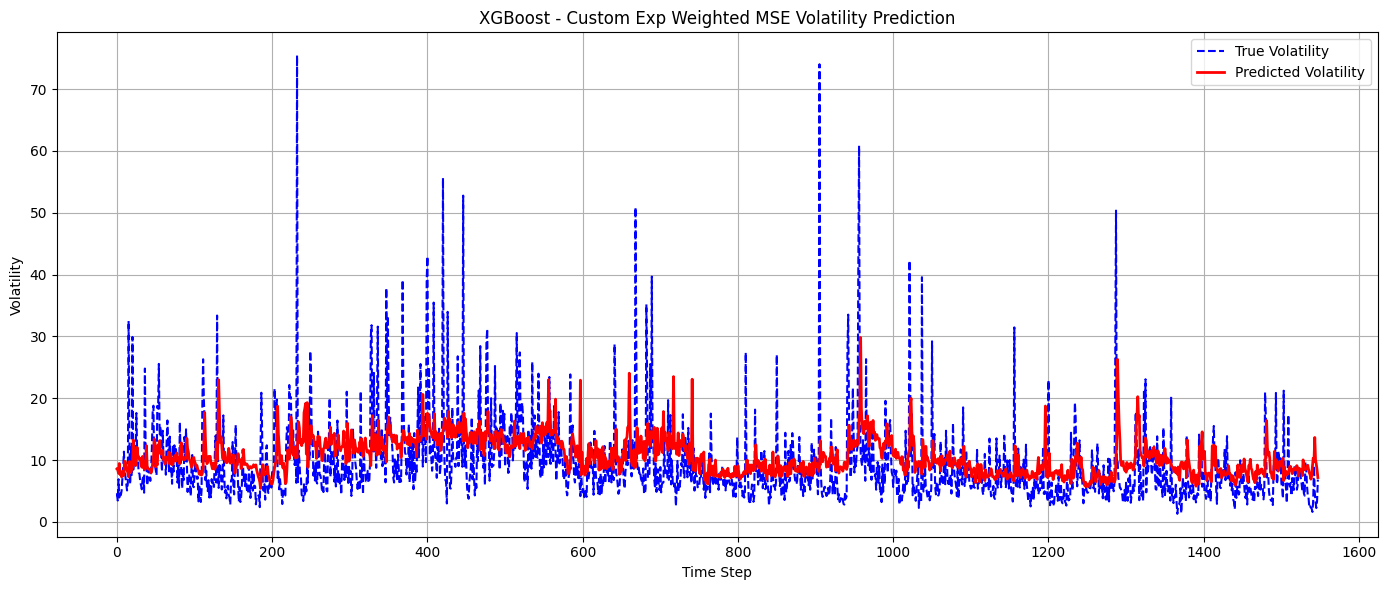

In [7]:
df_xgb['timestamp'] = pd.to_datetime(df_xgb['timestamp'])
df_garch['timestamp'] = pd.to_datetime(df_garch['timestamp'])
df_xgb_renamed = df_xgb.rename(columns={'pred': 'xgb_pred'})
df_garch_renamed = df_garch.rename(columns={'pred': 'garch_pred'})



# Merge on common timestamps
ensemble_df = pd.merge(df_xgb_renamed, df_garch_renamed, on='timestamp', how='inner')
print(ensemble_df.shape)
ensemble_df['ensemble_pred'] = (0.5 * ensemble_df['xgb_pred'] + 0.5 * ensemble_df['garch_pred']) 

splits = np.array_split(ensemble_df['ensemble_pred'], 6)
trues = np.array_split(all_trues, 6)

for i in range(len(splits)):
    rmse = np.sqrt(mean_squared_error(trues[i], splits[i])) / 100  # Undo percentage scaling
    mae = mean_absolute_error(trues[i], splits[i]) / 100
    print(f"Interval {i+1} - Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

plt.figure(figsize=(14, 6))
plt.plot(all_trues, label="True Volatility", color='blue', linestyle='--')
plt.plot(ensemble_df['ensemble_pred'], label="Predicted Volatility", color='red', linewidth=2)
plt.title("XGBoost - Custom Exp Weighted MSE Volatility Prediction")
plt.xlabel("Time Step")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# XGBoost with GCT features \& sentiment


[Window 1] Training on intervals 0-2, validating on 3, testing on 4


/Users/augustedarracqparies/Documents/Master/Paper ML/Git Code/TMM-for-BTC-volatility-prediction/Models/XGBoost.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_preds = pd.concat([all_preds, preds_df], ignore_index=True)



[Window 2] Training on intervals 1-3, validating on 4, testing on 5

[Window 3] Training on intervals 2-4, validating on 5, testing on 6

[Window 4] Training on intervals 3-5, validating on 6, testing on 7

[Window 5] Training on intervals 4-6, validating on 7, testing on 8

[Window 6] Training on intervals 5-7, validating on 8, testing on 9

[Summary]
   Window      RMSE       MAE
0       1  0.116497  0.099777
1       2  0.087048  0.062626
2       3  0.056564  0.035367
3       4  0.070645  0.038285
4       5  0.052929  0.036995
5       6  0.088552  0.078540


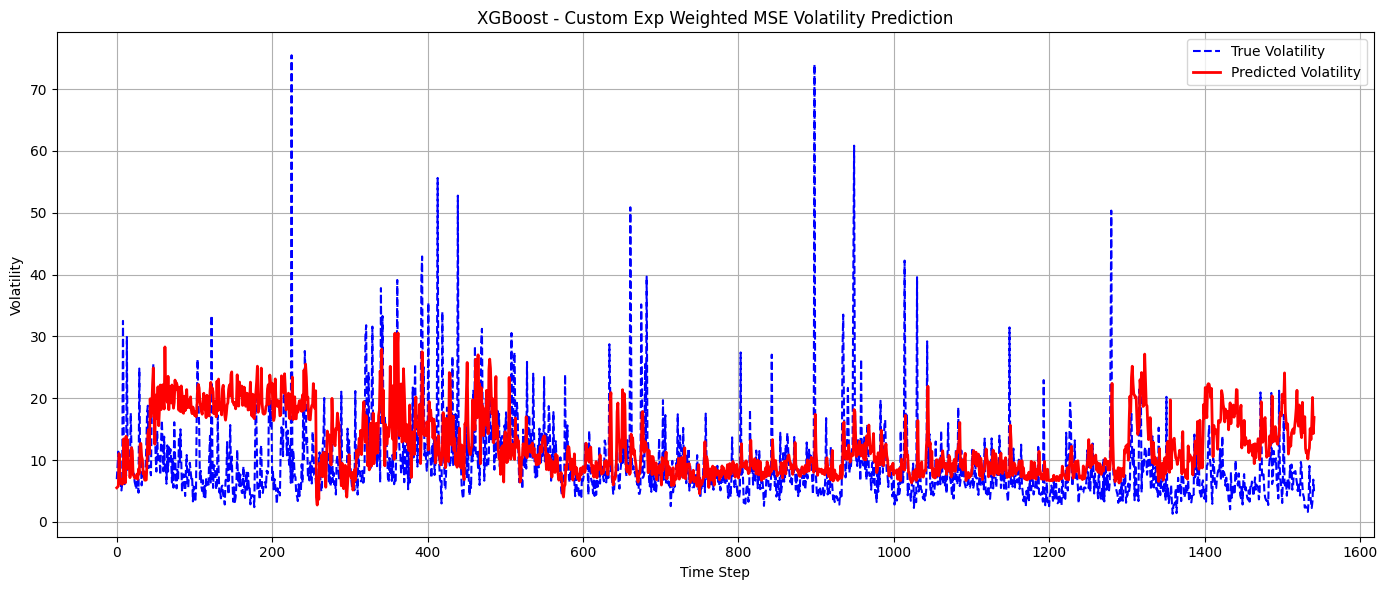

In [8]:
from Models.XGBoost import *

df = pd.read_csv('DATA/hourly_data_ff.csv')
sent = pd.read_csv('DATA/sentiment.csv')

granger_features = ['ask_depth', 'bid_depth', 'bid_volume', 'spread', 'volume_difference']
df = df[granger_features + ['vol', 'timestamp']]

feat_lags = {
    'aggregate_sentiment': 2,
    'fng_feature': 19,
    'ask_depth': 30,
    'bid_depth': 9,
    'bid_volume': 30,
    'spread':8,
    'volume_difference': 30,
    'returns': 1
}

df = pd.concat([df, sent[['Aggregate sentiment', 'fng_feature']], df_returns['returns'] **2], axis = 1)

results_xgb, df_xgb, all_trues = test_xgboost(df, feat_lags=feat_lags)